In [40]:
import os
import sys
sys.path.insert(0, '../scripts/')
from l5kit_modified import AgentDatasetModified
from kalman import KalmanTrackerPredictor
import pickle
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, create_chopped_dataset
from l5kit.evaluation.metrics import neg_multi_log_likelihood
from l5kit.data import LocalDataManager, ChunkedDataset
from pathlib import Path
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
    
os.environ["L5KIT_DATA_FOLDER"] = "../input/"

In [31]:
with open('../output/experiment__20200830-111447/best_parameters_18911.51709306535.pkl', 'rb') as f:
    kalman_params = pickle.load(f)

In [32]:
FILTER_AGENTS_THRESHOLD = 0.5
NUM_FRAMES_TO_CHOP = 100
FUTURE_NUM_FRAMES = 50
MIN_FUTURE_STEPS = 10
BATCH_SIZE = 256
# dataset_path = 'scenes/validate.zarr'
dataset_path = 'scenes/sample.zarr'

dm = LocalDataManager(None)
eval_base_path = create_chopped_dataset(dm.require(dataset_path),
                                                     FILTER_AGENTS_THRESHOLD,
                                                     NUM_FRAMES_TO_CHOP,
                                                     FUTURE_NUM_FRAMES,
                                                     MIN_FUTURE_STEPS)
eval_gt_path = os.path.join(eval_base_path, 'gt.csv')

eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(dataset_path)).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
# eval_zarr = ChunkedDataset(eval_zarr_path).open()
# eval_mask = np.load(eval_mask_path)["arr_0"]
eval_zarr = ChunkedDataset(dm.require(dataset_path)).open()

cfg = {"model_params": {"history_num_frames": kalman_params["history_num_frames"],
                                    "history_step_size": kalman_params["history_step_size"],
                                    "future_num_frames": FUTURE_NUM_FRAMES,
                                    "future_step_size": 1},
                   "raster_params": {"filter_agents_threshold": FILTER_AGENTS_THRESHOLD}}

del kalman_params['history_num_frames']
del kalman_params['history_step_size']

extracting GT:   3%|▎         | 15/480 [00:00<00:03, 147.97it/s]

warning, you're running with a custom agents_mask


extracting GT: 100%|██████████| 480/480 [00:03<00:00, 146.03it/s]


In [33]:
dataset = AgentDatasetModified(cfg, eval_zarr, agents_mask=eval_mask)
dataloader = DataLoader(dataset, shuffle=False, batch_size=1,
                        num_workers=2,
                        collate_fn=lambda x: x)

warning, you're running with a custom agents_mask


In [34]:
data_iter = iter(dataloader)
data = next(data_iter)

In [35]:
history_measurements = np.hstack((data[0]['history_positions'],
                                      data[0]['history_velocities']))
kalman_params.update({'init_measurements': history_measurements[0]})
kalman_tracker_predictor = KalmanTrackerPredictor(**kalman_params)
kalman_tracker_predictor.process_history(history_measurements)
future_coords_offsets = kalman_tracker_predictor.predict_future_positions()

In [36]:
future_coords_offsets

array([[[-1.05801833e-02,  6.91358680e-02],
        [ 5.77482823e-01,  1.07781597e+00],
        [ 1.15482615e+00,  2.10255873e+00],
        [ 1.72144979e+00,  3.14336414e+00],
        [ 2.27735374e+00,  4.20023220e+00],
        [ 2.82253801e+00,  5.27316292e+00],
        [ 3.35700260e+00,  6.36215629e+00],
        [ 3.88074751e+00,  7.46721231e+00],
        [ 4.39377273e+00,  8.58833098e+00],
        [ 4.89607827e+00,  9.72551230e+00],
        [ 5.38766413e+00,  1.08787563e+01],
        [ 5.86853031e+00,  1.20480629e+01],
        [ 6.33867680e+00,  1.32334322e+01],
        [ 6.79810360e+00,  1.44348641e+01],
        [ 7.24681073e+00,  1.56523587e+01],
        [ 7.68479817e+00,  1.68859159e+01],
        [ 8.11206593e+00,  1.81355358e+01],
        [ 8.52861400e+00,  1.94012184e+01],
        [ 8.93444239e+00,  2.06829636e+01],
        [ 9.32955110e+00,  2.19807714e+01],
        [ 9.71394012e+00,  2.32946419e+01],
        [ 1.00876095e+01,  2.46245751e+01],
        [ 1.04505591e+01,  2.597

In [37]:
data[0]['history_positions']

array([[  0.       ,   0.       ],
       [ -0.6275635,  -0.9484863],
       [ -1.2175903,  -1.9182129],
       [ -1.8330688,  -2.857666 ],
       [ -2.4545898,  -3.791504 ],
       [ -3.1329346,  -4.690918 ],
       [ -3.7797852,  -5.5874023],
       [ -4.410034 ,  -6.508545 ],
       [ -5.065674 ,  -7.4069824],
       [ -5.6602173,  -8.342285 ],
       [ -6.3793945,  -9.234131 ],
       [ -7.1811523, -10.107178 ],
       [ -7.7507935, -11.003662 ],
       [ -8.315918 , -11.899414 ],
       [ -8.878418 , -12.800049 ],
       [ -9.473694 , -13.889404 ],
       [-10.021973 , -14.45752  ],
       [-10.658569 , -15.466309 ],
       [-11.2438965, -16.33545  ],
       [-11.826843 , -17.208984 ],
       [-12.587585 , -18.127197 ],
       [-13.477295 , -19.106445 ],
       [-13.977539 , -19.968262 ],
       [-13.94104  , -21.115967 ],
       [-14.550293 , -21.93042  ],
       [-15.1692505, -22.73584  ],
       [-15.792603 , -23.548828 ],
       [-16.673462 , -24.325195 ],
       [-16.975708 ,

In [38]:
data[0].keys()

dict_keys(['target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent', 'label_probabilities', 'history_velocities'])

In [39]:
data[0]['target_positions']

array([[ 0.6135864 ,  0.96435547],
       [ 1.2299805 ,  1.9335938 ],
       [ 1.8994751 ,  2.8764648 ],
       [ 2.526123  ,  3.8549805 ],
       [ 3.2017822 ,  4.8085938 ],
       [ 3.8516846 ,  5.779541  ],
       [ 4.5216675 ,  6.7355957 ],
       [ 5.185608  ,  7.725342  ],
       [ 5.850464  ,  8.697266  ],
       [ 6.501587  ,  9.654785  ],
       [ 7.1538696 , 10.618164  ],
       [ 7.795288  , 11.660156  ],
       [ 8.483093  , 12.656006  ],
       [ 9.131958  , 13.689941  ],
       [ 9.741089  , 14.720703  ],
       [10.388794  , 15.73999   ],
       [11.054749  , 16.72461   ],
       [11.720276  , 17.715576  ],
       [12.394775  , 18.693115  ],
       [13.068237  , 19.673828  ],
       [13.64502   , 20.63916   ],
       [14.303406  , 21.618652  ],
       [14.92804   , 22.618164  ],
       [15.552307  , 23.637451  ],
       [16.182007  , 24.648193  ],
       [16.812317  , 25.660645  ],
       [17.472778  , 26.685303  ],
       [18.121765  , 27.694092  ],
       [18.76123   ,

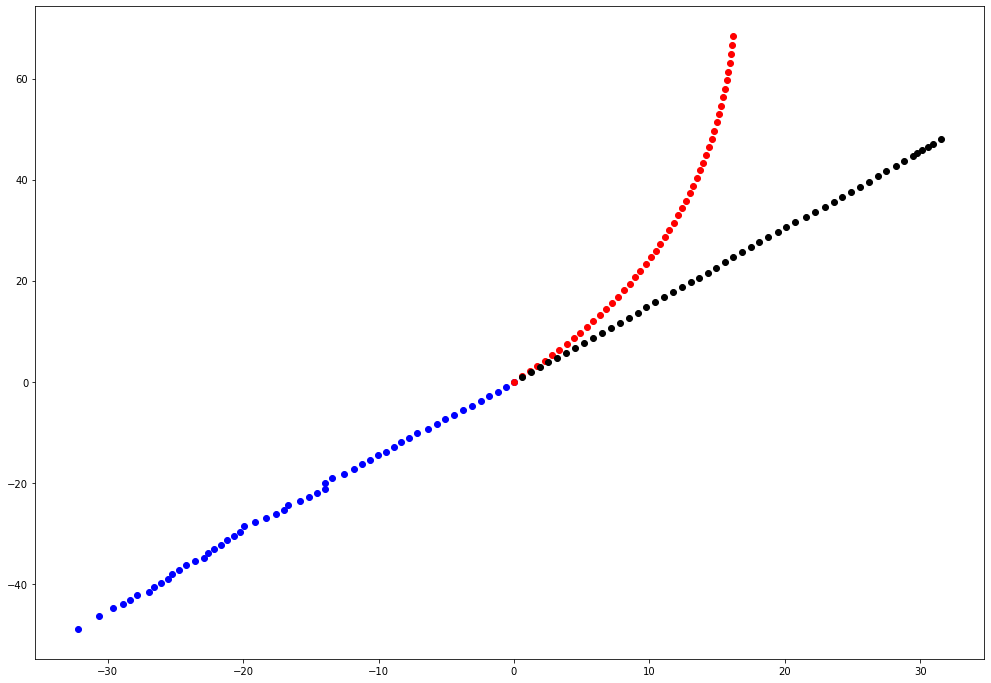

In [50]:
plt.figure(figsize=(17, 12))
plt.scatter(data[0]['history_positions'][:54, 0], data[0]['history_positions'][:54, 1], c='b')
plt.scatter(future_coords_offsets[0][:, 0], future_coords_offsets[0][:, 1], c='r')
plt.scatter(data[0]['target_positions'][:54, 0], data[0]['target_positions'][:54, 1], c='black')